In [121]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

In [122]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

In [123]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


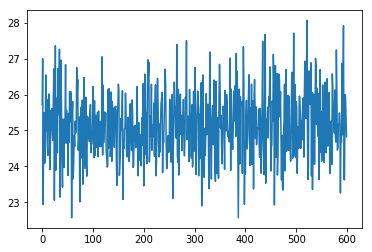

In [124]:
plt.plot(nino34[::12]);

In [125]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [126]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [127]:
clm = climatology(nino34)

In [128]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [129]:
anm = SST_anomaly(nino34, clm)
oni = ONI(anm)

# Data Preparation [FULL FEATURE SET]

In [130]:
T = 7      # prediction timeline
H = 48   # history used for prediction
include_month = 1           # 1 if we use the month as a feature, 0 otherwise
threshold = 0.5         
signal = np.array(anm)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [131]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + include_month))
for i in range(size):
    if(include_month == False):
         data[i] = signal[i:(i + H)]
    else:
        data[i] = np.append(signal[i:(i + H)], (i + H + T) % 12)

labels = np.ndarray((size), dtype = np.float64)
        
for i in range(size):
    labels[i] = oni[i + H + T]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

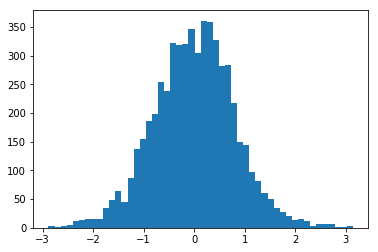

In [132]:
plt.hist(train_labels, bins=50);

# Random Forest

In [133]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor()
model.fit(train,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Training

In [134]:
MSE = mean_squared_error(train_labels , model.predict(train))
print(MSE, correlation(train_labels, model.predict(train)))

0.08189051121034896 0.9473683004590798


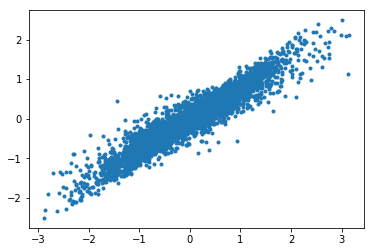

In [135]:
plt.plot(train_labels, model.predict(train), ".");

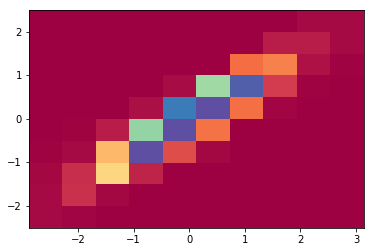

In [136]:
plt.hist2d(train_labels, model.predict(train), cmap = plt.cm.Spectral, vmax = 500);

# Validation

In [137]:
# MSE and Correlation on validation data
predicted = model.predict(val)
MSE = mean_squared_error(val_labels , predicted)
print(MSE, correlation(val_labels, predicted))

0.4416187984586411 0.5661331784822973


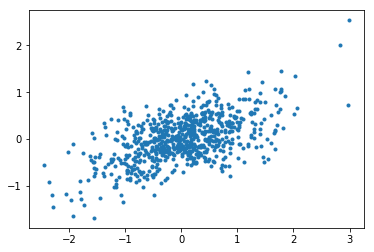

In [138]:
plt.plot(val_labels, model.predict(val), ".");

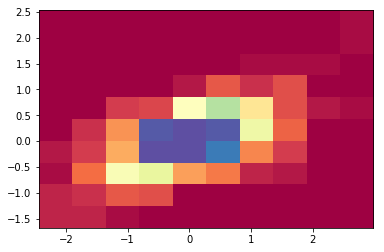

In [139]:
plt.hist2d(val_labels, model.predict(val), cmap = plt.cm.Spectral, vmax = 50);

# Support Vector Regressor

In [140]:
from sklearn import svm

model = svm.SVR()
model.fit(train,train_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Training

In [141]:
MSE = mean_squared_error(train_labels , model.predict(train))
print(MSE, correlation(train_labels, model.predict(train)))

0.2948579101061299 0.7501070172952773


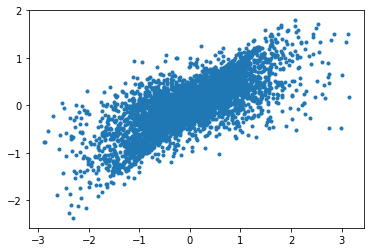

In [142]:
plt.plot(train_labels, model.predict(train), ".");

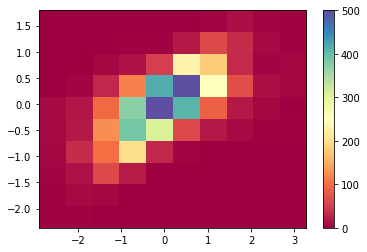

In [143]:
plt.hist2d(anm[train_ind + H + T], model.predict(train), cmap = plt.cm.Spectral, vmax = 500);
plt.colorbar();

# Validation

In [144]:
predicted = model.predict(val)
MSE = mean_squared_error(val_labels , predicted)
print(MSE, correlation(val_labels, predicted))

0.44604003740443965 0.559067624150373


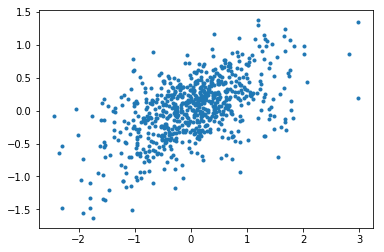

In [145]:
plt.plot(val_labels, model.predict(val), ".");

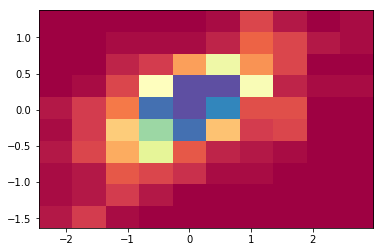

In [146]:
plt.hist2d(val_labels, model.predict(val), cmap = plt.cm.Spectral, vmax = 50);

# Data Preparation [REDUCED FEATURE SET VERSION 1]

In [147]:
input_signal = np.array(anm).copy()
output_signal = np.array(oni).copy()

In [148]:
mean = np.mean(input_signal)
std = np.std(input_signal)

input_signal = (input_signal - mean) / std

In [149]:
T = 7
H = 3  
Hmax = 48
features = H + 7 + 6 + 1 # 3 months of values / 7 x 3-month averages / 6 x 4-month months / current month

In [150]:
np.random.seed(0)
size = input_signal.shape[0] - Hmax - T 
        
data = np.ndarray((size, features))
for i in range(size):
    data[i, 0:H] = input_signal[(i + Hmax - H):(i + Hmax)] # past H exact values
    
    for j in range(7): # 7 x 3-month average
        data[i, H + j] = np.mean(input_signal[(i + Hmax - H - 3 * (j + 1)):(i + Hmax - H - 3 * j)])
    
    for j in range(6): # 6 x 4-month months
        data[i, H + 7 + j] = np.mean(input_signal[(i + Hmax - H - 3 * 7 - 4 * (j + 1)):(i + Hmax - H - 3 * 7 - 4 * j)])
        
    data[i, H + 7 + 6] = ((i + Hmax) % 12 - np.mean(range(12))) / np.std(range(12)) # current month
    

labels = np.ndarray(size, dtype = np.float64)

for i in range(size):
    labels[i] = output_signal[i + Hmax + T]

In [151]:
split = size // 10      

train = np.array(data[0: 8 * split])
train_labels = np.array(labels[0: 8 * split])

val = np.array(data[8 * split: 9 * split])
val_labels = np.array(labels[8 * split: 9 * split])

test = np.array(data[9 * split: size])
test_labels = np.array(labels[9 * split: size])

In [152]:
shuffle = np.random.permutation(8 * split)
train = train[shuffle]
train_labels = train_labels[shuffle]

# Random Forest

In [153]:
model = RandomForestRegressor()
model.fit(train,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [154]:
MSE = mean_squared_error(train_labels , model.predict(train))
print("Training:", MSE, correlation(train_labels, model.predict(train)))

Training: 0.061850773929727675 0.9588196358023101


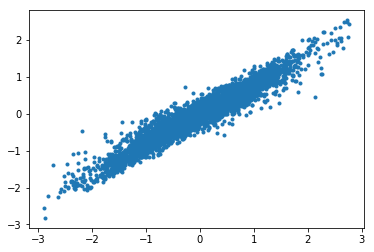

In [155]:
plt.plot(train_labels, model.predict(train), ".");

In [156]:
predicted = model.predict(val)
MSE = mean_squared_error(val_labels , predicted)
print("Validation:", MSE, correlation(val_labels, predicted))

Validation: 0.7268829561841248 0.33525604208686294


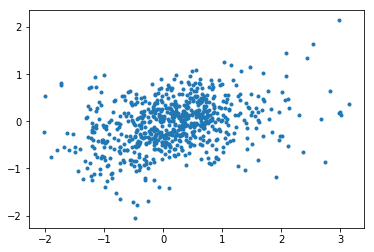

In [157]:
plt.plot(val_labels, model.predict(val), ".");

# Support Vector Regressor

In [158]:
model = svm.SVR()
model.fit(train,train_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [159]:
MSE = mean_squared_error(train_labels , model.predict(train))
print(MSE, correlation(train_labels, model.predict(train)))

0.3133255965912548 0.7100698927961445


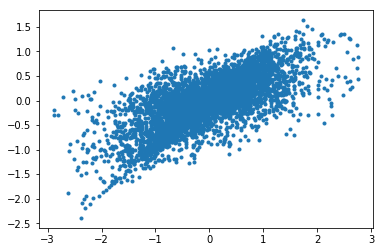

In [160]:
plt.plot(train_labels, model.predict(train), ".");

In [161]:
predicted = model.predict(val)
MSE = mean_squared_error(val_labels , predicted)
print("Validation:", MSE, correlation(val_labels, predicted))

Validation: 0.6806560022668818 0.37954463444900377


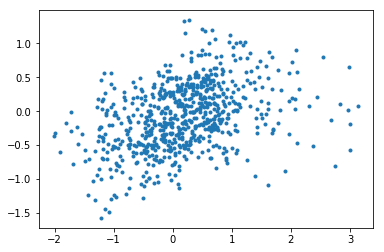

In [162]:
plt.plot(val_labels, model.predict(val), ".");